## 1. Loading data

We start by importing the libraries we need: 
- sklearn and numpy to do machine learning, 
- csv and pickle read the data and write out submission and model files, 
- time and os to keep organized with the files we output,
- matplotlib to perform visualizations.
We also import some specific sklearn components as well as an utils library with some handy extra functions.

In [1]:
import sklearn
import numpy as np
import csv
import pickle
import time
import os
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV

import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))


from utils_general import utils_for_students

In [2]:
train_samples = utils_for_students.load_dataset_stage2('../data/stage2_labels_train.csv', 'train')
test_samples = utils_for_students.load_dataset_stage2('../data/stage2_ids_test.csv', 'test')

In [3]:
train_samples[0].keys()

dict_keys(['path', 'id', 'label', 'signer'])

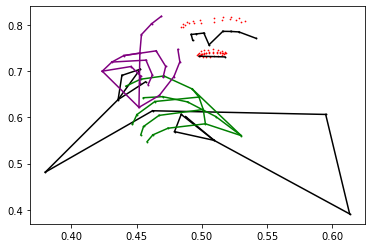

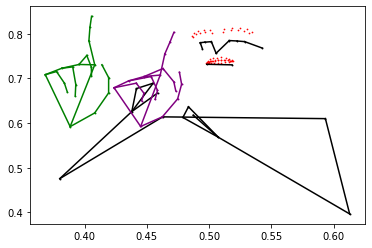

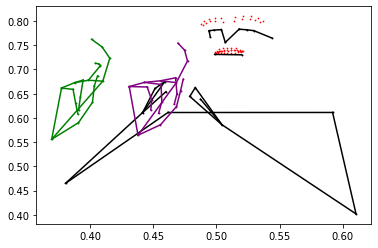

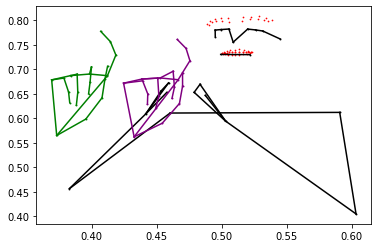

In [5]:
SAMPLE_INDEX = 4
sample = train_samples[SAMPLE_INDEX]
pose_sequence = utils_for_students.load_sample_stage2(os.path.join('../data/stage2/train/', sample['path']))

from utils_feature_preprocessing.split_features_into_frames import transform_to_k_frames
from utils_feature_preprocessing.correct_zero_values import correct_zeros
from utils_feature_preprocessing.enlarge_hands import enlarge_hands

pose_sequence = correct_zeros(pose_sequence)
pose_sequence = transform_to_k_frames(pose_sequence, k=4)
pose_sequence = enlarge_hands(pose_sequence, scale_factor=1.5)

for FRAME_INDEX in range(pose_sequence.shape[0]):
    utils_for_students.visualize_pose(pose_sequence[FRAME_INDEX], plt)
    plt.show()

In order to get a better grasp of every class in the dataset, we provide some additional information here.

There are 15 different classes. Each class corresponds to a sign. Signs can be annotated using sign glosses, which are representations of signs in written form in a spoken language. In the below table, we list all glosses, the English meaning of the corresponding sign, and provide a link to the Flemish sign language dictionary so that you can see an example performance of that sign.

| Gloss             | English meaning | Dictionary URL                                                                                        |
|-------------------|-----------------|-------------------------------------------------------------------------------------------------------|
| c.AF              | Done, finished  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AF/AF-B-209.mp4          |
| c.OOK             | Too, also       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/OO/OOK-A-8491.mp4        |
| ZELFDE-A          | The same        | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/ZE/ZELFDE-A-14290.mp4    |
| AUTO-RIJDEN-A     | To drive a car  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/RI/RIJDEN-C-9982.mp4     |
| HEBBEN-A          | To have         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HE/HEBBEN-A-4801.mp4     |
| HAAS-oor          | Hare            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HA/HAAS-B-16147.mp4      |
| AANKOMEN-A        | To arrive       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AA/AANKOMEN-A-39.mp4     |
| SCHILDPAD-Bhanden | Turtle          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/SC/SCHILDPAD-A-10503.mp4 |
| WAT-A             | What            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/WA/WAT-A-13657.mp4       |
| c.ZIEN            | To see          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/BE/BEKIJKEN-A-1157.mp4   |
| NAAR-A            | Towards         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GA/GA-NAAR-A-4032.mp4    |
| MOETEN-A          | To must         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/MO/MOETEN-D-17652.mp4    |
| C: 1              | 1               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/1-/1-A-15277.mp4         |
| GOED-A            | Good            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GO/GOED-C-4413.mp4       |
| C: 2              | 2               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/2-/2-A-15278.mp4         |

## 3. Feature Extraction

For stage 1, we performed feature extraction for you.

In this stage, you will need to perform feature extraction yourself.

In [6]:
from utils_feature_preprocessing.split_features_into_frames import transform_to_k_frames, frames_to_features
from utils_feature_preprocessing.correct_zero_values import correct_zeros
from utils_feature_preprocessing.enlarge_hands import enlarge_hands

def extract_features(pose_sequence):
    # You should implement this function to return better features!
    pose_sequence = correct_zeros(pose_sequence)
    pose_sequence = transform_to_k_frames(pose_sequence, k=4)
    pose_sequence = enlarge_hands(pose_sequence, scale_factor=2)
    features = frames_to_features(pose_sequence)
    
    return features

In [7]:
# Concatenate the training set features.
X_train = []
y_train = []
signers_train = []
for sample in train_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('../data/stage2/train/', sample['path']))
    X_train.append(extract_features(pose_sequence))
    y_train.append(sample['label'])
    signers_train.append(sample['signer'])
    
# Concatenate the test set features.
X_test = []
test_ids = []
for sample in test_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('../data/stage2/test/', sample['path']))
    X_test.append(extract_features(pose_sequence))
    test_ids.append(sample['id'])

#Combining to numpy array
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Encode the labels as integers
label_encoder = utils_for_students.label_encoder()
y_train = label_encoder.transform(y_train)

In [8]:
print(len(set(signers_train)))
unique_signers = set(signers_train)

38


In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape)

(2191, 1500) (2191,)
(541, 1500)


## 4. Creating pipelines for preprocessing and feature selection 

Now, we are ready to define our pipelines. You can create the same pipeline as for stage 1 as a baseline, but you will be expected to tune both the feature engineering
and pipeline parts of your model iteratively to improve your results.

In [10]:
# TODO: define preprocessing pipeline here
# It is up to you to define the number of modules in each pipeline and their types
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest,SelectFromModel,VarianceThreshold, RFE, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

preprocessing = Pipeline([
     ('scaler', StandardScaler()),
     ('decompose', PCA()),
                        ]) 

feature_selection = Pipeline([
    ('selectKBest', SelectKBest()),
                            ]) 

## 5. Define a suitable classifier
With your preprocessing and feature selection in place, it is now time to define the final element: a suitable classifier. 

In [11]:
from sklearn.linear_model import RidgeClassifier

classifier = RidgeClassifier(class_weight = "balanced")

## 6. Set up hyperparameter grid for [GridsearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) object.

Now, define your GridSearchCV hyperparameter grid and object.


In [12]:
param_grid = {
    'preprocessing__decompose__n_components': [None],
    'preprocessing__decompose__whiten': [False],
    'feature_selection__selectKBest__k': [300,500,700],
    'classifier__alpha': [0.1],
    'classifier__tol': [1.0e-3],
    'classifier__fit_intercept': [True]
}

## 7. Define the number of crossvaldation folds and how to split

Now, you should define the number of CV folds and how to split the data.
Assuming you had a correct split in the first stage of the competition, you can re-use the same code.


In [13]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold

#TODO: set appropriate number of cv folds
n_folds = 14  

# The function below is just an example!
#TODO: write a better split function here?
def create_folds(X,y,n_folds):
    folds = []
    cv_object = StratifiedGroupKFold(n_splits = n_folds)
    for (train_indices, val_indices) in  cv_object.split(X_train, y_train, groups=signers_train):
        folds.append((train_indices,val_indices))
    return folds

## 8. Training the model
Now it is time to put everything together and train the model. As you can see, `GridsearchCV` takes the pipelines as well as the classifier and the hyperparameter dictionary you defined, and uses `create_folds` to create list of train and test indices for each split. Then the model is trained using `cv.fit()` and the model and submission files are written to the file system.

In stage 2, this cell is no longer locked and you are free to edit it as you like.

In [14]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

folds = create_folds(X_train,y_train,n_folds)
assert isinstance(folds,list),'Folds must be presented as tuples of train and test index lists' 

# train model
cv = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=folds, verbose=1, return_train_score=True, refit=True)
cv.fit(X_train, y_train)

Fitting 14 folds for each of 3 candidates, totalling 42 fits


GridSearchCV(cv=[(array([   0,    1,    2, ..., 2187, 2189, 2190]),
                  array([  12,   16,   43,   65,   74,   85,   86,   91,  102,  103,  107,
        124,  130,  154,  159,  164,  170,  204,  209,  253,  279,  290,
        305,  313,  322,  351,  356,  361,  364,  366,  371,  394,  405,
        414,  424,  430,  437,  453,  455,  473,  474,  484,  533,  575,
        589,  616,  621,  633,  638,  644,  692,  735,  738,  743,  753,
        759,  762,  764,  765,  769,  772,  778,  782,  819,  823,  827,
        830,  839,  848,  854,  878,  901,  919,  922,  924...
                                                         SelectKBest())])),
                                       ('classifier',
                                        RidgeClassifier(class_weight='balanced'))]),
             n_jobs=4,
             param_grid={'classifier__alpha': [0.1],
                         'classifier__fit_intercept': [True],
                         'classifier__tol': [0.001],
       

## 9. Printing scores
Here we simply extract a bit more information about the individual scores obtained by the classifers we trained to fit the individual folds. Maybe a few plots may be useful to better understand what your classifier is doing? 

In [15]:
results = cv.cv_results_
mean_train_score = results['mean_train_score'][cv.best_index_]
std_train_score = results['std_train_score'][cv.best_index_]
mean_cv_score = results['mean_test_score'][cv.best_index_]
std_cv_score = results['std_test_score'][cv.best_index_]

print('Training accuracy {} +/- {}'.format(mean_train_score, std_train_score))
print('Cross-validation accuracy: {} +/- {}'.format(mean_cv_score, std_cv_score))

print('Best estimator:')
print(cv.best_estimator_)

Training accuracy 0.9107264554515435 +/- 0.00493060409040539
Cross-validation accuracy: 0.6811145938601838 +/- 0.09216783788857302
Best estimator:
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('decompose', PCA())])),
                ('feature_selection',
                 Pipeline(steps=[('selectKBest', SelectKBest(k=300))])),
                ('classifier',
                 RidgeClassifier(alpha=0.1, class_weight='balanced'))])


## 10. Confusion matrix

Normalized confusion matrix


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

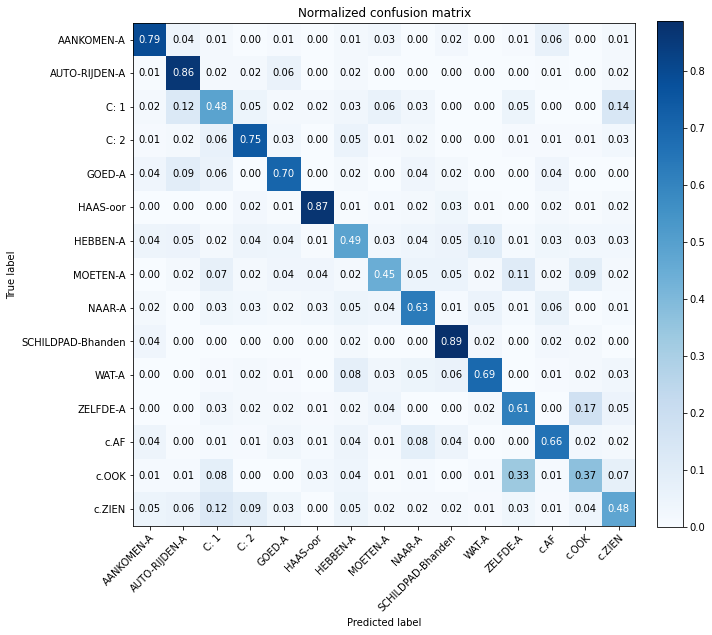

In [16]:
from utils_general.utils_for_students import label_encoder
from utils_data_analysis.confusion_matrix import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict


CLASSES = label_encoder().inverse_transform([i for i in range(len(label_encoder().classes_))])
y_pred = cross_val_predict(cv.best_estimator_, X_train, y_train, cv=folds, n_jobs=5) 
cv.best_estimator_.predict(X_train)
plot_confusion_matrix(y_train, y_pred, classes=CLASSES, normalize=True)

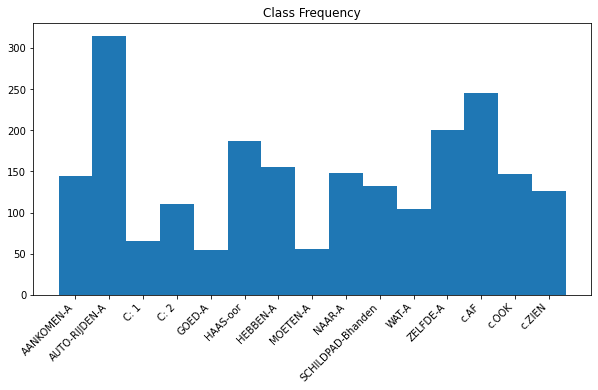

In [39]:
from matplotlib import pyplot as plt
import pandas as pd

plt.figure(figsize = (10,5))
data_class = pd.DataFrame(label_encoder().inverse_transform(y_train))
unique, counts = np.unique(data_class, return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()